# Ames Housing Data and Kaggle Challenge
## Modeling
***

*Import libraries and read in data:*

In [1]:
# Imports:

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# Read in the train and test data files and replaced all NaNs with 'NA'
train = pd.read_csv('../datasets/train_clean_dummies.csv', na_filter = False,)
test  = pd.read_csv('../datasets/test_clean_dummies.csv', na_filter = False)

In [3]:
# Verifying all nulls are gone
train.isnull().sum().sum()

0

In [4]:
# drop 'Unnamed: 0' column that was created when we saved the cleaned dataset (old index)
train.drop(columns = 'Unnamed: 0', inplace = True)
test.drop(columns = 'Unnamed: 0', inplace = True)

In [5]:
# Get shape of both - train has one more column than test as expected
print('Train Shape: ', train.shape)
print('Test Shape: ', test.shape)

Train Shape:  (2022, 88)
Test Shape:  (879, 87)


### Baseline Score (Mean)
***

In [6]:
# Reference: notes from feature-selection notebook by Sam Stack

# Baseline Score with Median of SalePrice as prediction
y = train['SalePrice']             # target
y_bar = [np.mean(y) for _ in y]    # predictions (mean)

In [7]:
print('RMSE: ', np.sqrt(mean_squared_error(y, y_bar)))
print('r2: ', r2_score(y, y_bar))

RMSE:  78985.0916950185
r2:  0.0


### Model Prep
***

In [8]:
# Select features to use
abs(train.corr()['SalePrice']).sort_values(ascending=False).head(40)

SalePrice                          1.000000
Total Quality * Above Ground SF    0.885021
Total Quality                      0.829114
Overall Qual                       0.802094
Above Ground SF                    0.728805
Gr Liv Area                        0.719911
Exter Qual                         0.714292
Neighborhood Quality               0.713592
Kitchen Qual                       0.692597
Total Bsmt SF                      0.664496
Garage Area                        0.657729
1st Flr SF                         0.650123
Garage Cars                        0.649914
Baths                              0.648360
Bsmt Qual                          0.609237
Home Age                           0.572272
Year Remod/Add                     0.549242
Fireplace Qu                       0.540010
Full Bath                          0.538497
Foundation_PConc                   0.529992
Finished Basement                  0.522911
Mas Vnr Area                       0.518978
TotRms AbvGrd                   

Good features (from Polynomial Feature feature selection process):
- Neighborhood Quality * Above Ground SF (interaction term already created)
- Neighborhood Quality * Bsmt Exposure_Gd 
- Neighborhood Quality * BsmtFin SF 1
- Full Bath * MS SubClass_60
- BsmtFin SF 1
- Overall Qual * Kitchn Qual ^2 (interaction term already created, but not yet squared)

In [9]:
# Add some new features from feature selection process
# train['Neighborhood Quality * Bsmt Exposure_Gd'] = train['Neighborhood Quality'] * train['Bsmt Exposure_Gd']
# train['Neighborhood Quality * BsmtFin SF 1'] = train['Neighborhood Quality'] * train['BsmtFin SF 1']
# train['Full Bath * MS SubClass_60'] = train['Full Bath'] * train['MS SubClass_60']
# train['Overall Qual * Kitchen Qual^2'] = train['Overall Qual * Kitchen Qual'] ** 2

### Initial Model Fitting
***

In [10]:
# Start with a model that contains the top correlated features with some of the polynomial features
# I will then make the model simpler
top_features = abs(train.corr()['SalePrice']).sort_values(ascending=False).head(70).keys()
features = [col for col in top_features if col != 'SalePrice']
# for col in ['Neighborhood Quality * Bsmt Exposure_Gd', 'Neighborhood Quality * BsmtFin SF 1', 
#                 'Full Bath * MS SubClass_60', 'Overall Qual * Kitchen Qual^2', 'Total Quality']:
#    features.append(col)

In [11]:
# Create X and y variables
X = train[features]
y = train['SalePrice']

In [12]:
# Train/test split (90/10 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

In [13]:
# Scaling
ss = StandardScaler()
ss.fit(X_train)
X_train_s = ss.transform(X_train)
X_test_s = ss.transform(X_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


In [14]:
# Instantiate models
lr = LinearRegression()
lasso = LassoCV(n_alphas=200)
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

In [15]:
# Cross Validation
print('LR Score: ', cross_val_score(lr, X_train_s, y_train, cv=5).mean())
print('Lasso Score: ', cross_val_score(lasso, X_train_s, y_train, cv=5).mean())
print('Ridge Score: ', cross_val_score(ridge, X_train_s, y_train, cv=5).mean())

LR Score:  0.9136501542624769


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The defaul

Lasso Score:  0.9143270998011921
Ridge Score:  0.9138030222019571


In [16]:
# Proceed with lasso...want to see what features it gets rid of

# Fit the model
lasso.fit(X_train_s, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=200, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [17]:
# Score the model
print('Train Score: ', lasso.score(X_train_s, y_train))
print('Test Score: ', lasso.score(X_test_s, y_test))
print('CV Score: ', cross_val_score(lasso, X_train_s, y_train, cv=5).mean())

Train Score:  0.9242854783660992
Test Score:  0.9435443524463655


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The defaul

CV Score:  0.9143270998011921


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [18]:
# Make predictions
y_hat = lasso.predict(X_test_s)

In [19]:
print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_hat)))
print('r2: ', r2_score(y_test, y_hat))

RMSE:  21494.321843776488
r2:  0.9435443524463655


In [20]:
[print(col, ":",  value) for col, value in zip(features, lasso.coef_)  if abs(value) > 1500];

Total Quality * Above Ground SF : 86291.62819529334
Total Quality : -2548.29041080467
Above Ground SF : -35421.39886429794
Exter Qual : -2660.456347726024
Neighborhood Quality : 4772.096659120682
Kitchen Qual : -2345.6439034233335
Garage Area : 3387.0315969244234
Bsmt Qual : -7845.789285476185
Year Remod/Add : 4263.9453696129885
Fireplace Qu : 2235.2899890487756
Finished Basement : 16308.833542585702
Mas Vnr Area : 2923.558878955003
Fireplaces : 1977.4164988478935
Heating QC : 1999.9260073829757
Neighborhood_NridgHt : 2111.905036667896
Mas Vnr Type_None : 2361.853539742268
Bsmt Exposure_Gd : 3881.8021361315637
MS SubClass_60 : -1986.953673073786
Garage Type_Attchd : 1541.8017069008888
Sale Type_New : 4158.241504592964
Lot Area : 5106.60870915758
BsmtFin Type 1 : -3378.160774439053
Mas Vnr Type_Stone : 2443.786507428797
Paved Drive_Y : 1559.3928823353012
Central Air : 1610.043307787338
Roof Style_Hip : 4113.987692888241
Neighborhood_StoneBr : 2720.078585655833
Roof Style_Gable : 2601.71

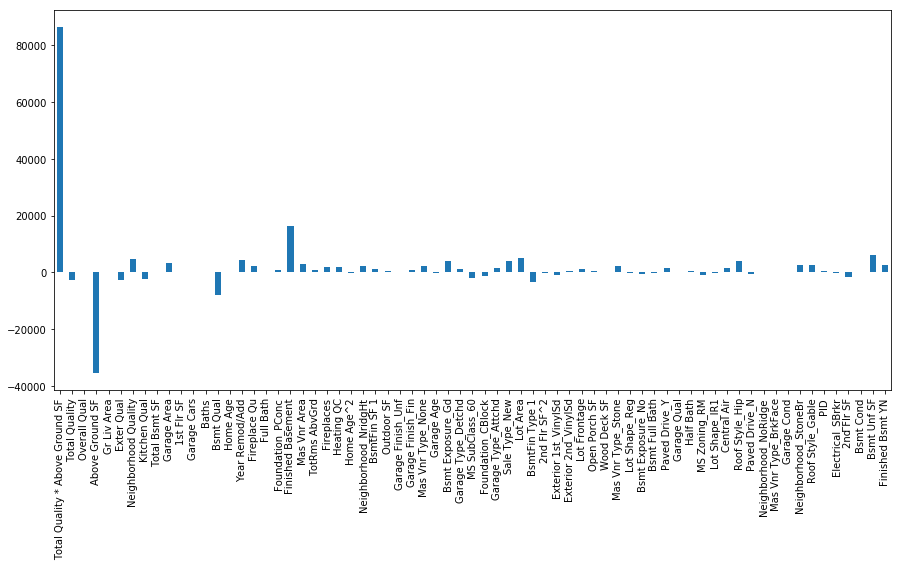

In [21]:
# Reference: code adapted from Riley Dallas's lesson on model workflow
pd.Series(lasso.coef_, index=features).plot.bar(figsize=(15, 7));

Observations:
- Some of the negative values may be due to multicolinearity: Total Quality and Above Ground SF, Garage Cars

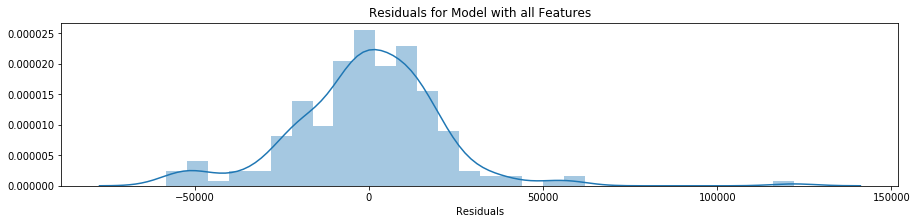

In [22]:
# Plot residuals
plt.figure(figsize=(15,3))
sns.distplot(y_test - y_hat, bins=30)
plt.title('Residuals for Model with all Features')
plt.xlabel('Residuals');

Observations:
- Residuals are relatively normally distributed
- There are some to the left 

### Model Adjustments - Explainable Model
***

In [23]:
# Pick just a few features I believe to be important based on lasso
 
features = ['Total Quality * Above Ground SF',
            'Neighborhood Quality',
            'Garage Area',
            'Finished Basement',
            'Year Remod/Add',
            'Mas Vnr Area',
            'Fireplaces',
            'Heating QC',
            'Bsmt Exposure_Gd',
            'Sale Type_New',
            'Lot Area',
            'Bsmt Unf SF']

In [24]:
# Score with these features
# Create X and y variables
X = train[features]
y = train['SalePrice']

# Train/test split (90/10 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

# Scaling
ss = StandardScaler()
ss.fit(X_train)
X_train_s = ss.transform(X_train)
X_test_s = ss.transform(X_test)

# Instantiate models
lr = LinearRegression()
lasso = LassoCV(n_alphas=200)
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

# Cross Validation
print('LR Score: ', cross_val_score(lr, X_train_s, y_train, cv=5).mean())
print('Lasso Score: ', cross_val_score(lasso, X_train_s, y_train, cv=5).mean())
print('Ridge Score: ', cross_val_score(ridge, X_train_s, y_train, cv=5).mean())

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  del sys.path[0]
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value f

LR Score:  0.8976023281547943
Lasso Score:  0.8976299357705624
Ridge Score:  0.8975839707588872


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [25]:
oldR2 = cross_val_score(lr, X_train_s, y_train, cv=5).mean()

In [26]:
# Try to see if any additional features add to my r2 score
for x in ['Garage Type_Attchd', 'MS Zoning_RM', 'Central Air', 'Roof Style_Hip', 'Roof Style_Gable', 'Baths', 'Home Age',
            'Bedroom AbvGr', 'Outdoor SF']:
     
    features = ['Total Quality * Above Ground SF',
                'Neighborhood Quality',
                'Finished Basement',
                'Year Remod/Add',
                'Mas Vnr Area',
                'Fireplaces',
                'Heating QC',
                'Bsmt Exposure_Gd',
                'Sale Type_New',
                'Lot Area',
                'Bsmt Unf SF', 
                x]
    
    X = train[features]
    y = train['SalePrice']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)

    ss = StandardScaler()
    ss.fit(X_train)
    X_train_s = ss.transform(X_train)
    X_test_s = ss.transform(X_test)

    lr = LinearRegression()
    newR2 = cross_val_score(lr, X_train_s, y_train, cv=5).mean()
    
    if newR2 > oldR2:
        print(x,':', newR2-oldR2)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.6/site-packages/ipykernel

Baths : 0.00011037638135980021


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:26: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionW

Observation: none of these new variables appear to add enough to be influential. I will leave my model as is or even remove features

### Production Model
***

In [27]:
# Try a model with even less features - as the fist two features alone get a score of 0.88
features = ['Total Quality * Above Ground SF',
            'Neighborhood Quality',
            'Garage Area',
            'Finished Basement',
            'Lot Area',
            'Bsmt Unf SF', 
            'Sale Type_New']

In [28]:
# Create X and y variables
X = train[features]
y = train['SalePrice']

# Train/test split (90/10 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

# Scaling
ss = StandardScaler()
ss.fit(X_train)
X_train_s = ss.transform(X_train)
X_test_s = ss.transform(X_test)

# Instantiate models
lr = LinearRegression()
lasso = LassoCV(n_alphas=200)
ridge = RidgeCV(alphas=np.linspace(.1, 10, 100))

# Cross Validation
print('LR Score: ', cross_val_score(lr, X_train_s, y_train, cv=5).mean())
print('Lasso Score: ', cross_val_score(lasso, X_train_s, y_train, cv=5).mean())
print('Ridge Score: ', cross_val_score(ridge, X_train_s, y_train, cv=5).mean())

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: Fut

LR Score:  0.886567628540068


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


Lasso Score:  0.8865587934154927
Ridge Score:  0.8865579596709511


In [29]:
# Proceed with ridge to look at coefficients (slighly highest score)

# Fit the model
ridge.fit(X_train_s, y_train)

# Score the model
print('Train Score: ', ridge.score(X_train_s, y_train))
print('Test Score: ', ridge.score(X_test_s, y_test))
print('CV Score: ', cross_val_score(ridge, X_train_s, y_train, cv=5).mean())

# Make predictions
y_hat = ridge.predict(X_test_s)

print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_hat)))
print('r2: ', r2_score(y_test, y_hat))

Train Score:  0.8899724427845495
Test Score:  0.9149673825767395
CV Score:  0.8865579596709511
RMSE:  24483.032621722294
r2:  0.9149673825767395


In [30]:
[print(col, ":",  value) for col, value in zip(features, ridge.coef_)];

Total Quality * Above Ground SF : 45136.86829499045
Neighborhood Quality : 9951.454775375634
Garage Area : 5674.499735077319
Finished Basement : 23547.5716130512
Lot Area : 4965.668094761029
Bsmt Unf SF : 8926.784287299437
Sale Type_New : 7533.301911918446


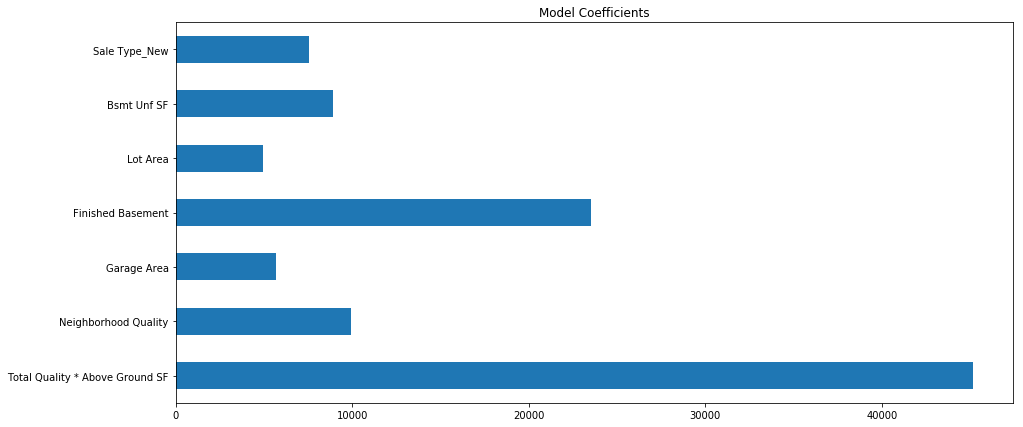

In [31]:
# Reference: code adapted from Riley Dallas's lesson on model workflow
fig = plt.figure()
pd.Series(ridge.coef_, index=features).plot.barh(figsize=(15, 7));
plt.title('Model Coefficients');

In [32]:
fig.savefig('../images/coefficients.png')

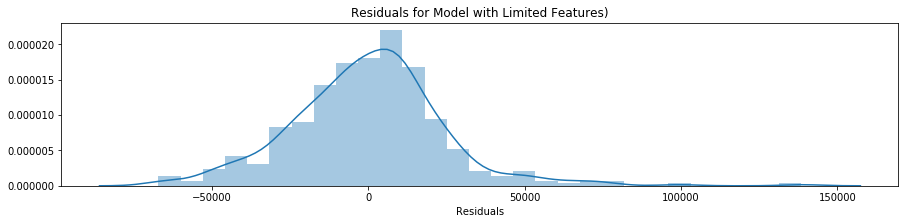

In [33]:
# Plot residuals
plt.figure(figsize=(15,3))
sns.distplot(y_test - y_hat)
plt.title('Residuals for Model with Limited Features)')
plt.xlabel('Residuals');

Observation: residuals are relatively normally distributed and around 0 with most falling between -50,000 and 50,000. There are some outliers to the right.

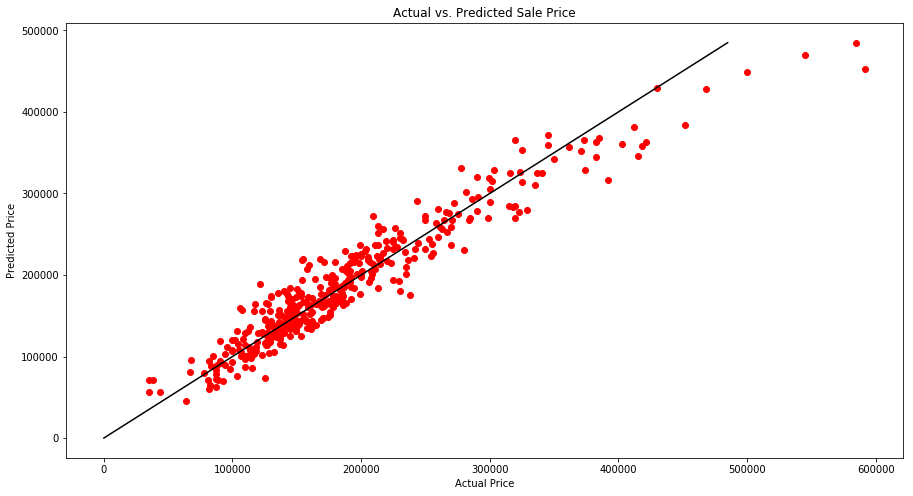

In [34]:
# Plot y vs. y_hat
fig = plt.figure(figsize=(15,8))
plt.scatter(y_test, y_hat, c = 'r');
plt.title('Actual vs. Predicted Sale Price')
plt.plot()
plt.xlabel('Actual Price');
plt.ylabel('Predicted Price')

# Reference: class notes on linear regression from Matt Brems
plt.plot([0, np.max(y_hat)], [0, np.max(y_hat)], c = 'k');

In [35]:
fig.savefig('../images/scatter.png')

In [36]:
# Power Transformer

# Create X and y variables
X = train[features]
y = train['SalePrice']

# Train/test split (90/10 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=42)


pt = PowerTransformer()
pt.fit(X_train)
X_train_pt = pt.transform(X_train)
X_test_pt = pt.transform(X_test)



pt_y = PowerTransformer()
# PowerTransformer requires a matrix/DataFrame, which is why we're using the .to_frame() method on y_train
pt_y.fit(y_train.to_frame()) 
y_train_pt = pt_y.transform(y_train.to_frame())
y_test_pt = pt_y.transform(y_test.to_frame())

# Fit the model
ridge.fit(X_train_pt, y_train_pt)

# Score the model
print('Train Score: ', ridge.score(X_train_pt, y_train_pt))
print('Test Score: ', ridge.score(X_test_pt, y_test_pt))
print('CV Score: ', cross_val_score(ridge, X_train_pt, y_train_pt, cv=5).mean())

# Make predictions
pred = ridge.predict(X_test_pt)
y_hat = pt_y.inverse_transform(pred.reshape(-1,1))
#y_hat = ridge.predict(X_test_s)

print('RMSE: ', np.sqrt(mean_squared_error(y_test, y_hat)))
print('r2: ', r2_score(y_test, y_hat))

Train Score:  0.8728855036825847
Test Score:  0.8872935579724176
CV Score:  0.8717093309126586
RMSE:  25373.13708707803
r2:  0.9213301666764515


Observation: best r2 yet

### Model Insights
***

* Which features appear to add the most value to a home?
   -  The features that are most important are Neighborhood (location), Above Ground SF (size), and Total Quality (quality)...these all make sense
* Which features hurt the value of a home the most?
   - Features that hurt the value of a home are an enclosed porch
* What are things that homeowners could improve in their homes to increase the value?
   - One big thing homeowners could improve in their homes to increase value is finish their basements
* What neighborhoods seem like they might be a good investment?
   - The top 3 neighborhoods: StoneBr, NridgHt, NoRidge
* Do you feel that this model will generalize to other cities? How * could you revise your model to make it more universal OR what date would you need from another city to make a comparable model?
   - I don't think this model would do that great in other cities
   - Real estate can differ greatly by city
   - An important thing I would need to make it more comparable to other cities is neighborhood informaiton